Code for "Regression on Initial DAG"

From the textbook: https://github.com/jrfiedler/causal_inference_python_code/blob/master/chapter12.ipynb

In [20]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import statsmodels.api as sm
from collections import OrderedDict
import matplotlib.pyplot as plt


In [21]:
url = 'https://raw.githubusercontent.com/sarahyurick/datasets/master/alc_merged.csv'
data = pd.read_csv(url)
data.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,3,yes,no,yes,no,yes,yes,yes,no,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,yes,yes,yes,yes,yes,yes,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,yes,no,yes,yes,no,no,4,3,2,1,2,5,4,6,10,10


In [22]:
drop_col = ['school', 'age', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime',
            'nursery']
data = data.drop(columns=drop_col)

# handle non-numeric features
struct_data = data.copy()
non_numeric_columns = list(struct_data.select_dtypes(exclude=[np.number]).columns)
# print(non_numeric_columns)
le = LabelEncoder()
for col in non_numeric_columns:
    struct_data[col] = le.fit_transform(struct_data[col])

data = struct_data
data.columns

Index(['sex', 'address', 'studytime', 'failures', 'schoolsup', 'famsup',
       'paid', 'activities', 'higher', 'internet', 'romantic', 'famrel',
       'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2',
       'G3'],
      dtype='object')

In [23]:
print(data['Dalc'].unique())
print(data['G3'].unique())

[1 2 5 3 4]
[ 6 10 15 11 19  9 12 14 16  5  8 17 18 13 20  7  0  4]


In [24]:
data['constant'] = 1

ave_grade_low_alc = data.loc[(data.Dalc == 1) | (data.Dalc == 2)].G3.mean()
ave_grade_high_alc = data.loc[(data.Dalc == 3) | (data.Dalc == 4) | (data.Dalc == 5)].G3.mean()

print("Average grade")
print("      drinkers: {:>0.1f}".format(ave_grade_high_alc))
print("  non-drinkers: {:>0.1f}".format(ave_grade_low_alc))

Average grade
      drinkers: 10.4
  non-drinkers: 10.8


In [25]:
ols = sm.OLS(data.G3, data[['constant', 'Dalc']])
res = ols.fit()
res.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
constant,11.2266,0.304,36.940,0.000,10.630,11.823
Dalc,-0.3334,0.172,-1.938,0.053,-0.671,0.004


In [26]:
est = res.params.Dalc
conf_ints = res.conf_int(alpha=0.05, cols=None)
lo, hi = conf_ints[0]['Dalc'], conf_ints[1]['Dalc']

print('            estimate   95% C.I.')
print('difference   {:>6.2f}   ({:>0.1f}, {:>0.1f})'.format(est, lo, hi))

            estimate   95% C.I.
difference    -0.33   (-0.7, 0.0)


In [27]:
data.head()

,sex,address,studytime,failures,schoolsup,famsup,paid,activities,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,constant
0,0,1,2,0,1,0,0,0,1,0,0,4,3,4,1,1,3,6,5,6,6,1
1,0,1,2,0,0,1,0,0,1,1,0,5,3,3,1,1,3,4,5,5,6,1
2,0,1,2,3,1,0,1,0,1,1,0,4,3,2,2,3,3,10,7,8,10,1
3,0,1,3,0,0,1,1,1,1,1,1,3,2,2,1,1,5,2,15,14,15,1
4,0,1,2,0,0,1,1,0,1,0,0,4,3,2,1,2,5,4,6,10,10,1


In [28]:
""" 'sex', 'address', 'studytime', 'failures', 'schoolsup', 'famsup',
       'paid', 'activities', 'higher', 'internet', 'romantic', 'famrel',
       'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2',
       'G3'
       """

summaries = OrderedDict((
    ('sex', lambda x: (100 * (x == 0)).mean()),
    ('address', lambda x: (100 * (x == 0)).mean()),
    ('studytime', 'mean'),
    ('failures', 'mean'),
    ('schoolsup', lambda x: (100 * (x == 0)).mean()),
    ('famsup', lambda x: (100 * (x == 0)).mean()),
    ('paid', lambda x: (100 * (x == 0)).mean()),
    ('activities', lambda x: (100 * (x == 0)).mean()),
    ('higher', lambda x: (100 * (x == 0)).mean()),
    ('internet', lambda x: (100 * (x == 0)).mean()),
    ('romantic', lambda x: 100 * x.mean()),
    ('famrel', 'mean'), 
    ('freetime', 'mean'), 
    ('goout', 'mean'), 
    ('health', 'mean'), 
    ('absences', 'mean')
))

table = data.groupby('Dalc').agg(summaries)
table.sort_index(ascending=False, inplace=True)
table = table.T

table.index = [
    'sex, % female',
    'address, % rural',
    'studytime, mean',
    'failures, mean',
    'schoolsup, % no schoolsup',
    'famsup, % no famsup',
    'paid, % no paid',
    'activities, % no activities',
    'higher, % no higher',
    'internet, % no internet',
    'romantic, % no romantic', 
    'famrel, mean', 
    'freetime, mean', 
    'goout, mean', 
    'health, mean', 
    'absences, mean'
]

table.style.format("{:>0.1f}")

Dalc,5,4,3,2,1
"sex, % female",11.8,38.9,24.4,47.5,67.8
"address, % rural",29.4,27.8,44.4,32.8,28.5
"studytime, mean",1.7,1.7,1.6,1.8,2.0
"failures, mean",0.4,0.4,0.5,0.4,0.3
"schoolsup, % no schoolsup",88.2,88.9,95.6,91.0,88.5
"famsup, % no famsup",17.6,50.0,57.8,38.5,38.5
"paid, % no paid",76.5,50.0,77.8,66.4,72.0
"activities, % no activities",29.4,55.6,57.8,54.1,51.3
"higher, % no higher",29.4,16.7,13.3,14.8,8.5
"internet, % no internet",11.8,22.2,26.7,23.0,24.3


In [29]:
for col in ['activities', 'studytime', 'goout', 'health', 'absences']:
    data['{}^2'.format(col)] = data[col] * data[col]

In [30]:
def logit_ip_f(y, X):
    """
    Create the f(y|X) part of IP weights
    from logistic regression
    
    Parameters
    ----------
    y : Pandas Series
    X : Pandas DataFrame
    
    Returns
    -------
    Numpy array of IP weights
    
    """
    model = sm.Logit(y, X)
    res = model.fit()
    weights = np.zeros(X.shape[0])
    weights[y == 1] = res.predict(X.loc[y == 1])
    weights[y == 0] = (1 - res.predict(X.loc[y == 0]))
    return weights

In [31]:
binary_dalc = []
for amount in data['Dalc']:
  if amount < 3:
    binary_dalc.append(0)
  else:
    binary_dalc.append(1)

data['binary_Dalc'] = binary_dalc
data.head()

,sex,address,studytime,failures,schoolsup,famsup,paid,activities,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,constant,activities^2,studytime^2,goout^2,health^2,absences^2,binary_Dalc
0,0,1,2,0,1,0,0,0,1,0,0,4,3,4,1,1,3,6,5,6,6,1,0,4,16,9,36,0
1,0,1,2,0,0,1,0,0,1,1,0,5,3,3,1,1,3,4,5,5,6,1,0,4,9,9,16,0
2,0,1,2,3,1,0,1,0,1,1,0,4,3,2,2,3,3,10,7,8,10,1,0,4,4,9,100,0
3,0,1,3,0,0,1,1,1,1,1,1,3,2,2,1,1,5,2,15,14,15,1,1,9,4,25,4,0
4,0,1,2,0,0,1,1,0,1,0,0,4,3,2,1,2,5,4,6,10,10,1,0,4,4,25,16,0


In [32]:
# 'activities', 'studytime', 'goout', 'health', 'absences'
"""
X_ip = data[[
    'constant',
    'sex', 'race', 'age', 'age^2', 'edu_2', 'edu_3', 'edu_4', 'edu_5',
    'smokeintensity', 'smokeintensity^2', 'smokeyrs', 'smokeyrs^2', 
    'exercise_1', 'exercise_2', 'active_1', 'active_2', 'wt71', 'wt71^2'
]]
"""

X_ip = data[[
             'constant', 
             'activities', 'studytime', 'studytime^2',
             'goout', 'goout^2',
             'health', 'health^2', 
             'absences', 'absences^2'
]]

denoms = logit_ip_f(data.binary_Dalc, X_ip)
weights = 1 / denoms

Optimization terminated successfully.
         Current function value: 0.320989
         Iterations 8


In [33]:
print('IP weights')
print('   min: {:>5.2f}   expected:  1.05'.format(weights.min()))
print('   max: {:>5.2f}   expected: 16.70'.format(weights.max()))
print('  mean: {:>5.2f}   expected:  2.00'.format(weights.mean()))

IP weights
   min:  1.00   expected:  1.05
   max: 53.42   expected: 16.70
  mean:  2.06   expected:  2.00


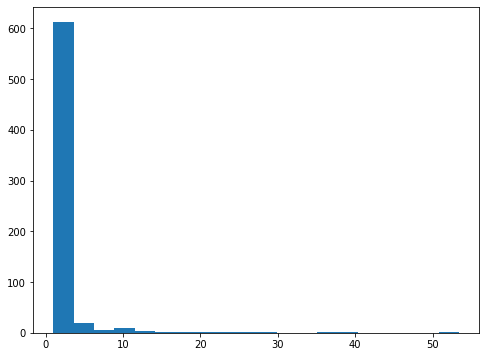

In [34]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.hist(weights, bins=20);

In [35]:
y = data.G3
X = data[['constant', 'binary_Dalc']]

In [36]:
wls = sm.WLS(y, X, weights=weights) 
res = wls.fit()
res.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
constant,10.7483,0.205,52.397,0.000,10.346,11.151
binary_Dalc,-0.4076,0.286,-1.425,0.155,-0.969,0.154


In [37]:
est = res.params.binary_Dalc
conf_ints = res.conf_int(alpha=0.05, cols=None)
lo, hi = conf_ints[0]['binary_Dalc'], conf_ints[1]['binary_Dalc']

print('           estimate   95% C.I.')
print('theta_1     {:>6.2f}   ({:>0.1f}, {:>0.1f})'.format(est, lo, hi))

           estimate   95% C.I.
theta_1      -0.41   (-1.0, 0.2)


Slightly modified, with ONLY studytime and health

In [38]:
# 'activities', 'studytime', 'goout', 'health', 'absences'

X_ip = data[[
             'constant', 
             'studytime', 'studytime^2',
             'health', 'health^2', 
]]

denoms = logit_ip_f(data.binary_Dalc, X_ip)
weights = 1 / denoms

Optimization terminated successfully.
         Current function value: 0.351560
         Iterations 7


In [39]:
print('IP weights')
print('   min: {:>5.2f}   expected:  1.05'.format(weights.min()))
print('   max: {:>5.2f}   expected: 16.70'.format(weights.max()))
print('  mean: {:>5.2f}   expected:  2.00'.format(weights.mean()))

IP weights
   min:  1.06   expected:  1.05
   max: 15.11   expected: 16.70
  mean:  1.99   expected:  2.00


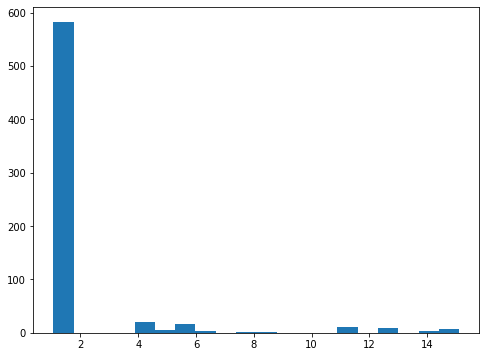

In [40]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.hist(weights, bins=20);

In [41]:
y = data.G3
X = data[['constant', 'binary_Dalc']]

In [42]:
wls = sm.WLS(y, X, weights=weights) 
res = wls.fit()
res.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
constant,10.7469,0.206,52.264,0.000,10.343,11.151
binary_Dalc,-0.6476,0.292,-2.219,0.027,-1.221,-0.074


In [43]:
est = res.params.binary_Dalc
conf_ints = res.conf_int(alpha=0.05, cols=None)
lo, hi = conf_ints[0]['binary_Dalc'], conf_ints[1]['binary_Dalc']

print('           estimate   95% C.I.')
print('theta_1     {:>6.2f}   ({:>0.1f}, {:>0.1f})'.format(est, lo, hi))

           estimate   95% C.I.
theta_1      -0.65   (-1.2, -0.1)
